# BERTFFTMLPClassifier Classificazione Binaria - LIAR DATASET

## CARICAMENTO DATI + PULIZIA E PREPARAZIONE

In [1]:
# 1. Caricamento dati e import iniziali (lasciare tutto come nel tuo codice originale)
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader


In [2]:
# 2. Caricamento dataset (come nel tuo codice originale)
col_names = ['ID', 'label', 'statement', 'subject', 'speaker', 'speaker\'s title', 'state', 'party', 'barely true', 'false', 'half true', 'mostly true', 'pants on fire', 'context', 'justification']
train_df = pd.read_csv('data/train2_clean.tsv', sep='\t', names=col_names)
test_df = pd.read_csv('data/test2_clean.tsv', sep='\t', names=col_names)
val_df = pd.read_csv('data/val2_clean.tsv', sep='\t', names=col_names)

# Pulizia dati
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)
val_df = val_df.fillna(0)

In [3]:
train_df.head()

,ID,label,statement,subject,speaker,speaker's title,state,party,barely true,false,half true,mostly true,pants on fire,context,justification
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,0,0,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,0,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


In [4]:
train_df['label'].value_counts()

,count
label,
half-true,2114
false,1995
mostly-true,1962
true,1676
barely-true,1654
pants-fire,839


In [5]:
print(f'Number of datapoints are {len(train_df)}')
print(f'Shape of df is {train_df.shape}')
train_df.info()

Number of datapoints are 10240
Shape of df is (10240, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10240 non-null  object 
 1   label            10240 non-null  object 
 2   statement        10240 non-null  object 
 3   subject          10240 non-null  object 
 4   speaker          10240 non-null  object 
 5   speaker's title  10240 non-null  object 
 6   state            10240 non-null  object 
 7   party            10240 non-null  object 
 8   barely true      10240 non-null  float64
 9   false            10240 non-null  float64
 10  half true        10240 non-null  float64
 11  mostly true      10240 non-null  float64
 12  pants on fire    10240 non-null  float64
 13  context          10240 non-null  object 
 14  justification    10240 non-null  object 
dtypes: float64(5), object(10)
memory usage: 1.2+ M

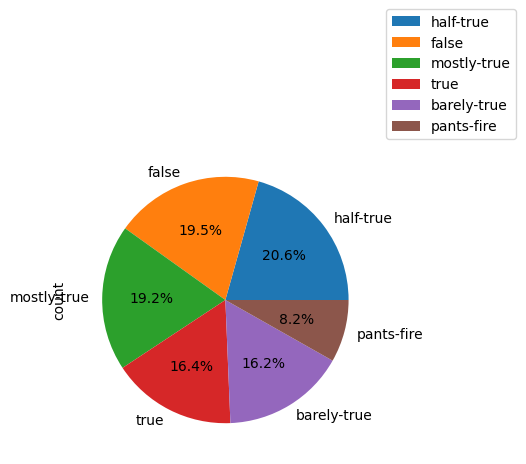

In [6]:
train_df["label"].value_counts().head(7).plot(kind = 'pie', autopct='%1.1f%%', figsize=(4, 4)).legend(bbox_to_anchor=(1, 1))

In [ ]:
# 2. Preprocessing e tokenizzazione
import re
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased', do_lower_case=True)

def preprocess_text(texts):
    processed = []
    for text in texts:
        text = str(text).lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#\w+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        processed.append(text.strip())
    return processed


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# 3. Encoding labels (come nel tuo codice originale)

def encode_labels(df):
    df['label'] = df['label'].map({
        'true': 1, 'mostly-true': 1, 'half-true': 1,
        'false': 0, 'barely-true': 0, 'pants-fire': 0
    })
    return df

train_df = encode_labels(train_df)
val_df = encode_labels(val_df)
test_df = encode_labels(test_df)


#Tokenizzazione testo

In [ ]:
# 4. Tokenizzazione statements (come nel tuo codice originale)

# Tokenizzazione
def tokenize_data(df, tokenizer, max_len=256):
    texts = preprocess_text(df['statement'])
    encodings = tokenizer.batch_encode_plus(
        texts,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return encodings

train_encodings = tokenize_data(train_df, tokenizer)
val_encodings = tokenize_data(val_df, tokenizer)
test_encodings = tokenize_data(test_df, tokenizer)

In [ ]:
# Creazione dataset
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    torch.tensor(train_df['label'].values).long()
)

val_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    torch.tensor(val_df['label'].values).long()
)

test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    torch.tensor(test_df['label'].values).long()
)

# Processing metadati

Approccio DistillBert + FFT (Fast Fourier Transform) con filtri

Classificatore ibrido basato su DistilBERT arricchito con un'analisi nel dominio delle frequenze.

Andiamo a combinare le rappresentazioni contestuali apprese da BERT con informazioni trasformate tramite FFT per catturare pattern frequenziali latenti nei vettori di embedding.

L'architettura la formiamo:

- Un backbone linguistico (DistilBERT)
- Due filtri frequenziali apprendibili che agiscono nel dominio delle frequenze
- Un modulo residuale per preservare le informazioni originali
- Una rete MLP profonda per la classificazione finale

Obbiettivo --> fondere rappresentazioni semantiche e frequenziali, cosi da migliorare la capacità discriminativa rispetto all’uso del solo BERT.

In [ ]:
import torch.nn as nn
from transformers import DistilBertModel

class BERTFFTMLPClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")

        # Filtri frequenziali appresi
        self.freq_filter1 = nn.Parameter(torch.randn(385))
        self.freq_filter2 = nn.Parameter(torch.randn(385))

        self.norm = nn.LayerNorm(1536)

        # Normalizzazione e residual
        self.residual_proj = nn.Linear(768, 1536)

        # MLP profondo
        self.mlp = nn.Sequential(
          nn.Linear(1536, 256),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(256, 512),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(512, 2)
      )

        self._init_weights()

    def _init_weights(self):
        for layer in self.mlp:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        pooled = outputs.last_hidden_state[:, 0, :]  # [batch_size, 768]

        # FFT → dominio frequenziale
        fft = torch.fft.rfft(pooled, dim=-1)  # [batch_size, 384]

        # Filtraggio frequenziale
        filtered1 = fft * self.freq_filter1
        filtered2 = fft * self.freq_filter2

        # Ritorno al dominio temporale
        ifft1 = torch.fft.irfft(filtered1, n=pooled.size(-1), dim=-1)
        ifft2 = torch.fft.irfft(filtered2, n=pooled.size(-1), dim=-1)

        # Concatenazione
        combined = torch.cat([ifft1, ifft2], dim=-1)  # [batch_size, 768]

        # Residual + Normalizzazione
        residual = self.residual_proj(pooled)
        fused = self.norm(combined + residual)

        # Classificazione
        return self.mlp(fused)

In [ ]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# 4. Configurazione training
BATCH_SIZE = 16
EPOCHS = 6
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.1
WARMUP_STEPS = 100

# Calcolo class weights
class_counts = train_df['label'].value_counts().sort_index()
class_weights = 1. / class_counts
class_weights = torch.tensor(class_weights.values, dtype=torch.float32).to(device)

In [ ]:
# Dataloaders
from torch.utils.data import RandomSampler, SequentialSampler

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=BATCH_SIZE
)

val_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=BATCH_SIZE
)

test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=BATCH_SIZE
)


# Inizializzazione modello
model = BERTFFTMLPClassifier().to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

 Freezing stratificato + MLP

Per migliorare la stabilità dell’addestramento e sfruttare progressivamente le capacità del modello pre-addestrato.
Inizialmente, solo il classificatore (MLP) e i filtri frequenziali vengono allenati, lasciando congelato DistilBERT.

A partire dalla terza epoca, si sbloccano gradualmente gli ultimi 3 layer del trasformatore, mentre nelle ultime epoche si allena l'intero modello.

L’ottimizzazione viene fatta con:

- AdamW, ottimizzatore robusto per modelli pre-addestrati
- Scheduler lineare con warmup, per evitare salti instabili all’inizio
- Loss ponderata (CrossEntropy), per bilanciare eventuali squilibri tra classi

Obbiettivo --> massimizzare la stabilità iniziale e poi permettere al modello di adattarsi progressivamente


In [ ]:
# 5. Freezing stratificato
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW


def set_requires_grad(model, epoch):
    # Epoche 1-2: solo MLP e filtri FFT
    if epoch < 2:
        for param in model.distilbert.parameters():
            param.requires_grad = False
        for param in model.mlp.parameters():
            param.requires_grad = True
        model.freq_filter1.requires_grad = True
        model.freq_filter2.requires_grad = True

    # Epoche 3-4: unfreeze ultimi 3 layer BERT
    elif epoch < 4:
        for i, layer in enumerate(model.distilbert.transformer.layer):
            if i >= 3:  # Ultimi 3 layer
                for param in layer.parameters():
                    param.requires_grad = True

    # Epoche 5-6: tutto trainable
    else:
        for param in model.parameters():
            param.requires_grad = True

# 6. Ottimizzatore e loss
optimizer = AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    eps=1e-8
)

total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
# 7. Training loop with early stopping
from sklearn.metrics import f1_score, roc_auc_score
import copy

def train_model():
    best_val_accuracy = 0
    best_model_state = None
    early_stop_counter = 0
    PATIENCE = 2

    training_stats = []

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch + 1}/{EPOCHS}")
        print("-" * 50)

        # Set gradient requirements
        set_requires_grad(model, epoch)

        # Training
        model.train()
        total_train_loss = 0
        total_train_correct = 0

        for step, batch in enumerate(train_dataloader):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            model.zero_grad()

            outputs = model(input_ids, attention_mask)

            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            total_train_correct += (preds == labels).sum().item()

            if step % 50 == 0:
                print(f"  Batch {step}/{len(train_dataloader)} - Loss: {loss.item():.4f}")

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_accuracy = total_train_correct / len(train_dataset)

        # Validation
        model.eval()
        total_val_loss = 0
        total_val_correct = 0
        all_preds = []
        all_labels = []

        for batch in val_dataloader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            with torch.no_grad():
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                total_val_correct += (preds == labels).sum().item()

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = total_val_correct / len(val_dataset)
        val_f1 = f1_score(all_labels, all_preds)
        val_roc_auc = roc_auc_score(all_labels, all_preds)

        # Salvataggio statistiche
        training_stats.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'train_acc': train_accuracy,
            'val_loss': avg_val_loss,
            'val_acc': val_accuracy,
            'val_f1': val_f1,
            'val_roc_auc': val_roc_auc
        })

        print(f"\n  Training Loss: {avg_train_loss:.4f}")
        print(f"  Training Accuracy: {train_accuracy:.4f}")
        print(f"  Validation Loss: {avg_val_loss:.4f}")
        print(f"  Validation Accuracy: {val_accuracy:.4f}")
        print(f"  Validation F1: {val_f1:.4f}")
        print(f"  Validation ROC-AUC: {val_roc_auc:.4f}")

        # Early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            early_stop_counter += 1
            if early_stop_counter >= PATIENCE:
                print(f"\nEarly stopping at epoch {epoch + 1}")
                break

    # Carica il miglior modello
    model.load_state_dict(best_model_state)
    return model, training_stats

Ricorda addestra DistillBert su 6 epoche perchè altrimenti con 8 il training impara troppo e la validation meno, andando cosi in overfitting

In [ ]:

# 8. Addestramento
trained_model, stats = train_model()


Epoch 1/8
--------------------------------------------------
  Batch 0/640 - Loss: 0.8194
  Batch 50/640 - Loss: 0.5996
  Batch 100/640 - Loss: 0.8155
  Batch 150/640 - Loss: 0.7079
  Batch 200/640 - Loss: 0.7182
  Batch 250/640 - Loss: 0.6133
  Batch 300/640 - Loss: 0.7797
  Batch 350/640 - Loss: 0.6446
  Batch 400/640 - Loss: 0.6787
  Batch 450/640 - Loss: 0.6648
  Batch 500/640 - Loss: 0.6567
  Batch 550/640 - Loss: 0.6109
  Batch 600/640 - Loss: 0.7305

  Training Loss: 0.7210
  Training Accuracy: 0.5437
  Validation Loss: 0.6666
  Validation Accuracy: 0.5919
  Validation F1: 0.6006
  Validation ROC-AUC: 0.5920

Epoch 2/8
--------------------------------------------------
  Batch 0/640 - Loss: 0.6664
  Batch 50/640 - Loss: 0.6448
  Batch 100/640 - Loss: 0.6250
  Batch 150/640 - Loss: 0.6976
  Batch 200/640 - Loss: 0.7428
  Batch 250/640 - Loss: 0.6491
  Batch 300/640 - Loss: 0.6326
  Batch 350/640 - Loss: 0.8114
  Batch 400/640 - Loss: 0.6430
  Batch 450/640 - Loss: 0.5603
  Batch

In [ ]:
# 9. Valutazione sul test set
from sklearn.metrics import confusion_matrix, classification_report

def evaluate(model, dataloader):
    model.eval()
    total_correct = 0
    all_preds = []
    all_labels = []

    for batch in dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            total_correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = total_correct / len(dataloader.dataset)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, digits=4)

    print(f"\nTest Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    print(f"Test ROC-AUC: {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(cr)

    return accuracy, f1, roc_auc

# Valutazione finale
test_accuracy, test_f1, test_roc_auc = evaluate(trained_model, test_dataloader)


Test Accuracy: 0.6567
Test F1 Score: 0.6904
Test ROC-AUC: 0.6534

Confusion Matrix:
[[347 206]
 [229 485]]

Classification Report:
              precision    recall  f1-score   support

           0     0.6024    0.6275    0.6147       553
           1     0.7019    0.6793    0.6904       714

    accuracy                         0.6567      1267
   macro avg     0.6522    0.6534    0.6525      1267
weighted avg     0.6585    0.6567    0.6574      1267

